#### Flux with MNIST and GPU


##### Libraries

In [1]:
using CUDA

using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

# using MLJ                  # make_blobs, rmse, confmat, f1score, coerce
using MLDataUtils          # label, nlabel, labelfreq, stratifiedobs
using Flux                 # the julia ml library

using Plots
using Random
using DataFrames

In [2]:
include("../libs/libml.jl")

stopTrainingCriteria (generic function with 1 method)

##### MNIST

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

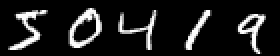

In [3]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2)  ; nrow=1)

In [4]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = MLDataUtils.stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

##### Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
tr_X, tr_y = preprocess(trainX, trainY)
d, N, size(tr_X), size(tr_y)

(784, 42001, (784, 42001), (10, 42001))

##### Model

In [6]:
# data on gpu
X_d = tr_X |> gpu
y_d = tr_y |> gpu;

In [7]:
# model configuration
nInputs  = d
nOutputs = 10

# Flux.Dense(nInputs, 256, tanh)
model = Chain( Dense(nInputs => 128, relu),
               Dense(128     => 32,  relu),
               Dense(32      => nOutputs),
               softmax)      |> gpu                                   # weights on gpu

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 32, relu),               # 4_128 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 104_938 parameters, 856 bytes.

In [8]:
lossFunction(X, y) = Flux.mse( model(X), y )
modelParameters    = Flux.params(model)
data               = Flux.DataLoader((X_d, y_d), batchsize=1)        # batchsize=1 => SGD, batch size > 1 => batch gradient descent
modelOptimizer     = Flux.Descent()
callBack           = Flux.throttle(() -> println("training"), 10);   # print every 10s

##### Training

In [9]:
numberOfEpochs = 500

500

Training method without plotting epochs

In [10]:
# # https://fluxml.ai/Flux.jl/stable/training/training/

# # preferred for multiple epochs
# epochs = 1:numberOfEpochs
# for epoch in epochs
#     Flux.train!(lossFunction, modelParameters, data, modelOptimizer; cb=callBack)
# end

Training epoch with plotting, with the aid of homemade function trainModel!

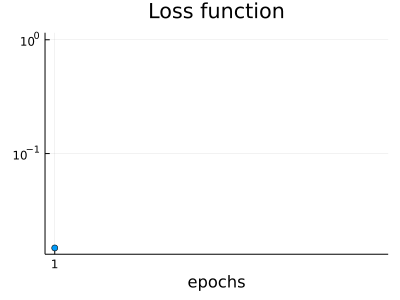

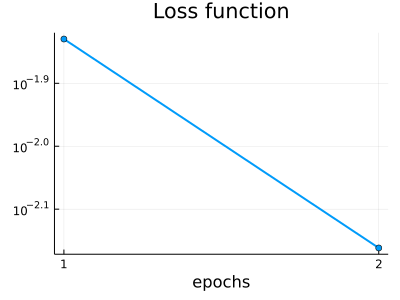

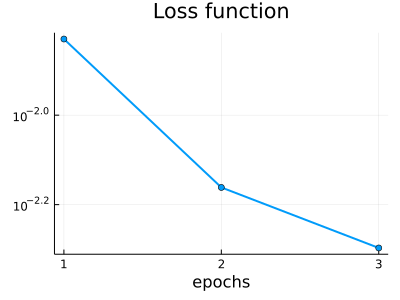

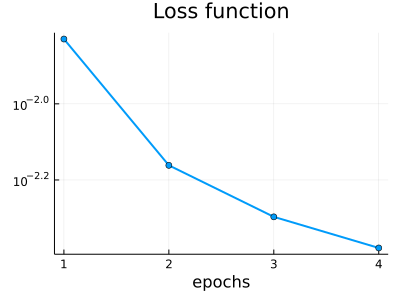

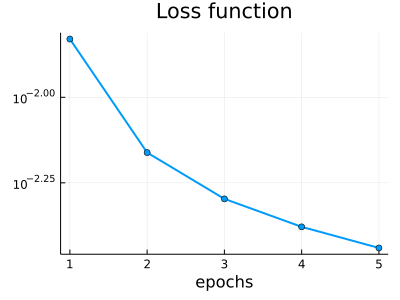

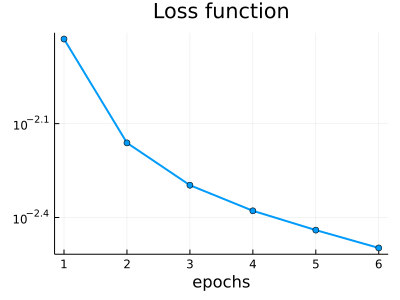

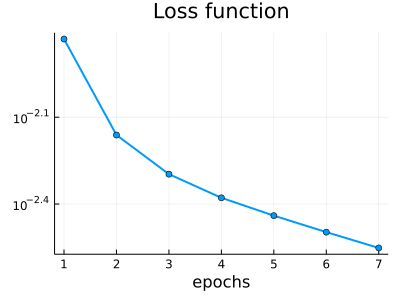

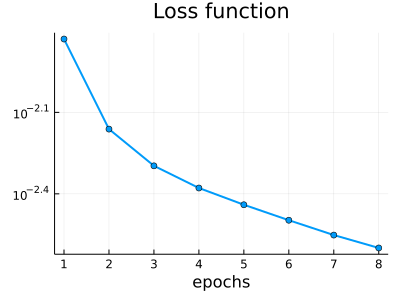

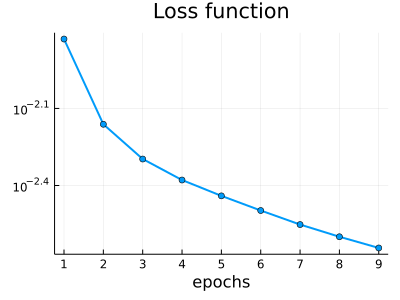

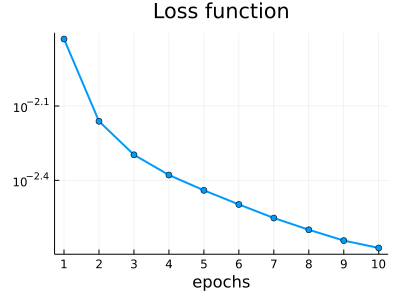

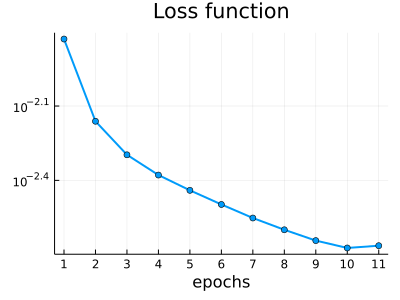

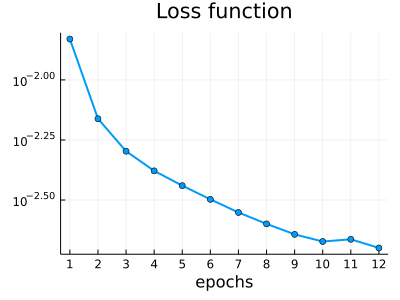

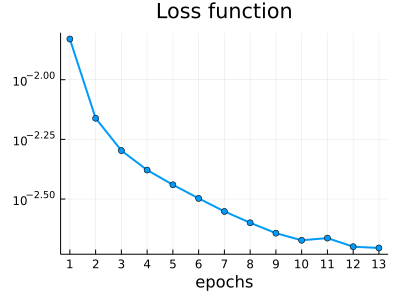

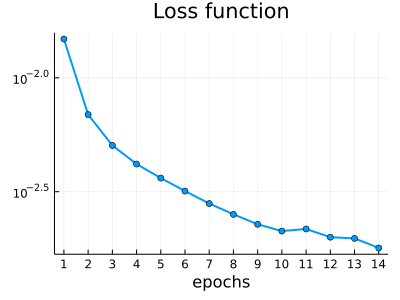

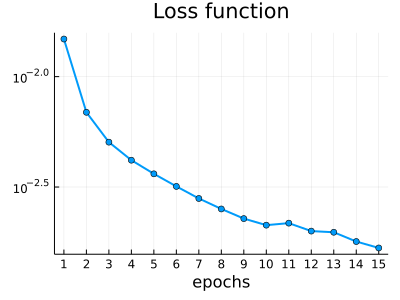

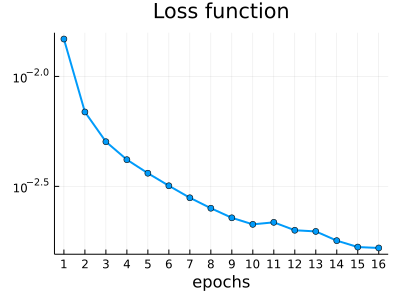

loss function with small variation


In [11]:
# https://fluxml.ai/Flux.jl/stable/training/training/

epochs     = 1 : numberOfEpochs
lossVector = Vector{Float64}()
minLoss    = 5e-4   # hint: start at 1e-2, then go lower for more epochs (5e-4)
nearZero   = minLoss / 25

for epoch in epochs
    # train epoch
    loss = trainModel!( lossFunction, modelParameters, data, modelOptimizer )   # libml
    push!(lossVector, loss)

    # plot evolution
    x = 1:size(lossVector)[1]
    y = lossVector
    display( plot(x, y,
             size        = (400,300),
             linewidth   = 2,
             markershape = :circle,
             legend      = false,
             xticks      = x,                   # force ticks to integer as the vector
             xlabel      = "epochs",
             yaxis       = :log,
             title       = "Loss function") )

    # exit criteria
    if stopTrainingCriteria(lossVector, minLoss, nearZero)   break   end
end

##### Testing

In [12]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

predictOutcome (generic function with 1 method)

In [13]:
# preprocessing
ts_X, ts_y = preprocess(testX, testY)
X_d        = ts_X |> gpu

# predict
ŷ = predictOutcome(X_d)

# result
printMetrics( ŷ, coerce(testY, OrderedFactor) )

10×10 Matrix{Int64}:
 1741     0     1     0     0     4     4     1     3     3
    1  1959     1     0     1     1     0     2     4     1
    4    14  1724     9     4     1     1     5     4     0
    3     7    10  1780     0     8     0     2    24    14
    3     1     5     0  1719     1     8     2     3    17
    5     2     8    26     0  1591    11     2    13    10
    9     7     3     1     2     5  1747     1    10     0
    4    19    21    12     6     3     0  1852     3    26
    5    11    10     7     5     6     4     4  1687    12
    2     3     4     4    16     6     0     8     4  1702

accuracy: 0.972
f1-score: 

0.972
